# Dense network regression demonstration

The ``torch_tools.DenseNetwork`` model can also be use for regression problems.

We need the same things as before:
* Some data:
    * We'll again use a dataset from ``scklearn``.
    * We will also need to load the data using a ``Dataset`` and ``DataLoader``.
* A model:
    * We will instantiate the model shortly.
* A loss function.
* A optimiser to fit the model with.


In the classification example, we asked the model to produce a discrete classification by obtaining a prediction from the maximum argument of the softmax's output. In this case, we will use the diabetes dataset from scikit learn.

In this case there are ten classes, and the output is a continuous, quantative measure of disease.

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True).frame


valid_data = data.sample(frac=0.2, random_state=123)
train_data = data.loc[~data.index.isin(valid_data.index)]

print(valid_data.shape)
print(train_data.shape)


target_keys = ["MedHouseVal"]
input_keys = list(filter(lambda x: x not in target_keys, data.keys()))

print(input_keys)
print(target_keys)

(4128, 9)
(16512, 9)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
['MedHouseVal']


Now we can create our dataset and dataloader objects as we did before.

In [2]:
from torch.utils.data import DataLoader
from torch_tools import DataSet


batch_size = 10


train_set = DataSet(
    inputs=tuple(train_data[input_keys].to_numpy()),
    targets=tuple(train_data[target_keys].to_numpy()),
)


valid_set = DataSet(
    inputs=tuple(valid_data[input_keys].to_numpy()),
    targets=tuple(valid_data[target_keys].to_numpy()),
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)


In [3]:
from torch_tools import DenseNetwork

model = DenseNetwork(
    in_feats=8,
    out_feats=1,
    hidden_sizes=(8, 8, 8),
    input_bnorm=True,
    hidden_bnorm=True,
    input_dropout=0.0,
    hidden_dropout=0.0,
)
print(model)

DenseNetwork(
  (0): InputBlock(
    (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): DenseBlock(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (4): DenseBlock(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


We also need a new loss function: this time—means-squared-error.

In [4]:
from torch.nn import MSELoss
from torch.optim import Adam

l1_loss = MSELoss(reduction="sum")

optimiser = Adam(model.parameters(), lr=1e-4)

Now we need to rewrite the training and validation functions to extract slightly different information than we did in the classification example.

In [5]:
from torch.nn import Module
from torch import no_grad


def train_one_epoch(
    model: Module,
    loss_func: MSELoss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the regression model for a single epoch.

    Parameters
    ----------
    model : Module
        PyTorch model.
    loss_func : MSELoss
        Loss function.
    optim : Adam
        Optimiser to train the function with.
    train_loader : DataLoader
        Training dataloader.

    Returns
    -------
    mean_loss : float
        Mean loss over the epoch.
    mean_ratio : float
        Mean preds to target ratio.


    """
    model.train()
    running_loss = 0.0
    running_ratio = 0.0
    for batch, targets in train_loader:
        batch, targets = batch.float(), targets.float()

        optim.zero_grad()

        preds = model(batch)

        loss = loss_func(preds, targets)

        loss.backward()

        optim.step()

        running_loss += loss.item()

        running_ratio += ((preds.detach() - targets).abs() / targets).sum()

    mean_loss = running_loss / len(valid_loader.dataset)
    mean_ratio = running_ratio / len(valid_loader.dataset)

    return mean_loss, mean_ratio


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: MSELoss,
    valid_loader: DataLoader,
):
    """Validate single epoch.

    Parameters
    ----------
    model : Module
        PyTorch model to validate.
    loss_func : MSELoss
        Loss function.
    valid_loader : DataLoader
        Validation DataLoader.

    Returns
    -------
    mean_loss : float
        Mean loss over the epoch.
    mean_ratio : float
        Mean preds to target ratio.

    """
    model.eval()
    running_loss = 0.0
    running_ratio = 0.0
    for batch, targets in valid_loader:
        batch, targets = batch.float(), targets.float()

        preds = model(batch)

        loss = loss_func(preds, targets)

        running_loss += loss.item()

        running_ratio += ((preds.detach() - targets).abs() / targets).sum()

    mean_loss = running_loss / len(valid_loader.dataset)
    mean_ratio = running_ratio / len(valid_loader.dataset)

    return mean_loss, mean_ratio

Now, let's train!

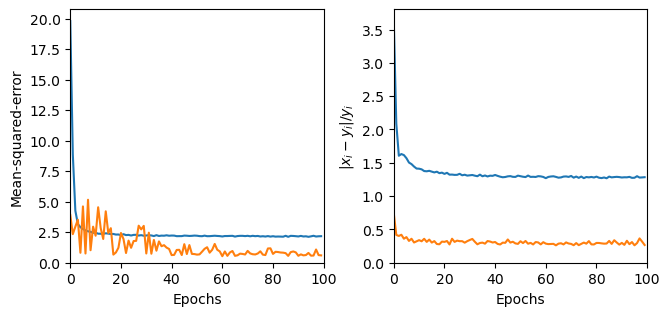

In [6]:
import matplotlib.pyplot as plt

metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_ratio": [],
    "valid_ratio": [],
}

for epoch in range(100):
    train_loss, train_ratio = train_one_epoch(
        model,
        l1_loss,
        optimiser,
        train_loader,
    )
    valid_loss, valid_ratio = validate_one_epoch(
        model,
        l1_loss,
        valid_loader,
    )

    metrics["train_loss"].append(train_loss)
    metrics["valid_loss"].append(valid_loss)
    metrics["train_ratio"].append(train_ratio)
    metrics["valid_ratio"].append(valid_ratio)


figure, axes = plt.subplots(1, 2)

axes[0].plot(metrics["train_loss"])
axes[0].plot(metrics["valid_loss"])

axes[1].plot(metrics["train_ratio"])
axes[1].plot(metrics["valid_ratio"])


axes[0].set_ylabel("Mean-squared-error")
axes[1].set_ylabel(r"$\left | x_{i} - y_{i} \right | / y_{i}$")

for axis in axes.ravel():
    axis.set_xlim(left=0.0, right=len(metrics["train_loss"]))
    axis.set_ylim(bottom=0.0)

    axis.set_xlabel("Epochs")

    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )
figure.tight_layout(pad=0.1)